# Swipe dataset cleaning

In [10]:
from datasets import Dataset, DatasetDict
import pandas as pd

train_df = pd.read_json('../data/swipe/swipe_train.json')
val_df = pd.read_json('../data/swipe/swipe_val.json')
test_id_df = pd.read_json('../data/swipe/swipe_test_id.json')
test_ood_df = pd.read_json('../data/swipe/swipe_test_ood.json')

train_dataset = Dataset.from_pandas(train_df[['r_content', 's_content','annotations','edits']])
val_dataset = Dataset.from_pandas(val_df[['r_content', 's_content','annotations','edits']])
test_id_dataset = Dataset.from_pandas(test_id_df[['r_content', 's_content','annotations','edits']])
test_ood_dataset = Dataset.from_pandas(test_ood_df[['r_content', 's_content','annotations','edits']])

swipe_dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test_id': test_id_dataset,
    'test_ood': test_ood_dataset
})

In [11]:
print("Train dataset: ", len(swipe_dataset['train']))
print("Validation dataset: ", len(swipe_dataset['validation']))
print("Test id dataset: ", len(swipe_dataset['test_id']))
print("Test ood dataset: ", len(swipe_dataset['test_ood']))

Train dataset:  3861
Validation dataset:  482
Test id dataset:  484
Test ood dataset:  377


# Check alignment

In [30]:
from bert_score import score
from tqdm import tqdm
import logging

# suppress warinings
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)


def compute_bertscore(r_texts, s_texts, batch_size=8):
    f1_scores = []
    for i in tqdm(range(0, len(r_texts), batch_size)):
        r_batch = r_texts[i:i+batch_size]
        s_batch = s_texts[i:i+batch_size]
        _, _, F1 = score(s_batch, r_batch, lang="en", verbose=False)
        f1_scores.extend(F1.numpy())
    return f1_scores


f1_scores = compute_bertscore(swipe_dataset['test_ood']['r_content'], swipe_dataset['test_ood']['s_content'])

100%|█████████████████████████████████████████████| 48/48 [00:54<00:00,  1.13s/it]


In [31]:
import pandas as pd

df_scores = pd.DataFrame({
    'r_content': swipe_dataset['test_ood']['r_content'],
    's_content': swipe_dataset['test_ood']['s_content'],
    'bert_score': f1_scores
})

df_scores.to_csv('../data/bert_scores/bert_scores_swipe-test_ood.csv', index=False)

## Train dataset

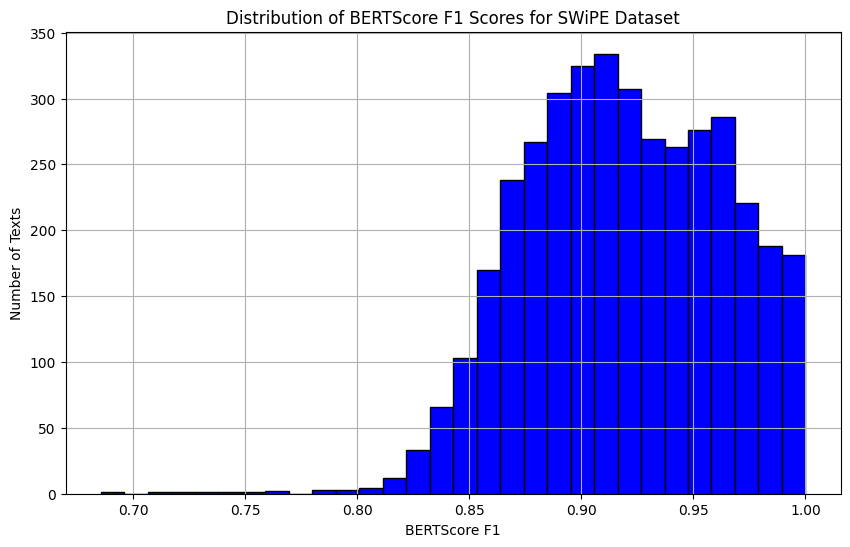

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_scores['bert_score'], bins=30, color='blue', edgecolor='black')
plt.title("Distribution of BERTScore F1 Scores for SWiPE Dataset")
plt.xlabel("BERTScore F1")
plt.ylabel("Number of Texts")
plt.grid(True)
plt.show()

In [16]:
for idx, row in df_scores[df_scores['bert_score']<=0.8].iterrows():
    print("ID = ", idx)
    print("Bscore = ", row['bert_score'])
    print("Raw: ",row['r_content'], end='\n\n')
    print(row['s_content'], end='\n\n')
    print("\n\n")

ID =  296
Bscore =  0.7942624092102051
Raw:  The apple is the pomaceous fruit of the apple tree, species Malus domestica in the rose family Rosaceae. It is one of the most widely cultivated tree fruits. The tree originated from Central Asia, where its wild ancestor is still found today. There are more than 7,500 known cultivars of apples resulting in a range of desired characteristics. Cultivars vary in their yield and the ultimate size of the tree, even when grown on the same rootstock.
At least 55 million tons of apples were grown worldwide in 2005, with a value of about $10 billion. China produced about 35% of this total. The United States is the second leading producer, with more than 7.5% of world production. Iran is third followed by Turkey, Russia, Italy and India.

The apple is a fleshy fruit from the apple tree. It is in the species Malus domestica in the rose family Rosaceae. The apple is one of the most grown tree fruits.
The apple tree came from Central Asia. Its wild ances

In [17]:
indices_to_delete = df_scores[df_scores['bert_score']<=0.8].index.tolist()
print("Num records to delete: ", len(indices_to_delete))

Num records to delete:  14


In [39]:
print("Num of records: ", len(train_df))
train_df.drop(indices_to_delete, inplace=True)
print("Num of records: ", len(train_df))

Num of records:  3861
Num of records:  3847


## Validation dataset

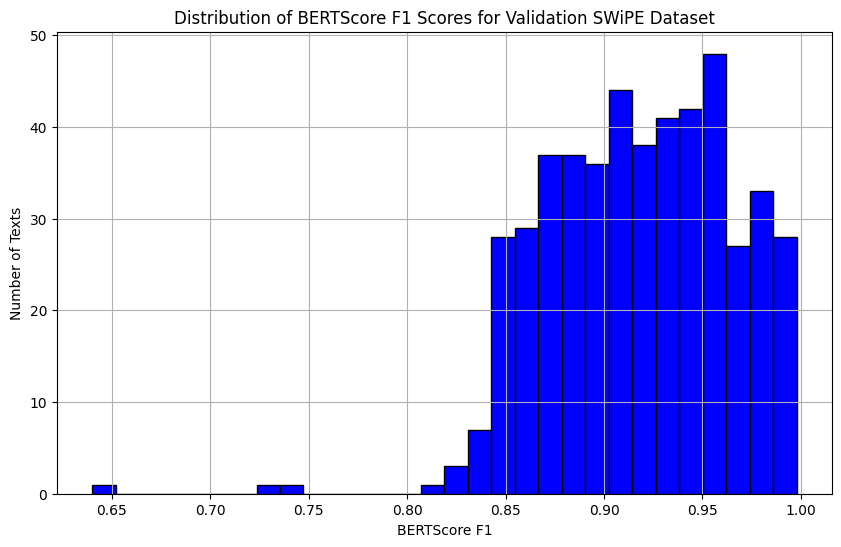

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_scores['bert_score'], bins=30, color='blue', edgecolor='black')
plt.title("Distribution of BERTScore F1 Scores for Validation SWiPE Dataset")
plt.xlabel("BERTScore F1")
plt.ylabel("Number of Texts")
plt.grid(True)
plt.show()

In [21]:
for idx, row in df_scores[df_scores['bert_score']<=0.80].iterrows():
    print("ID = ", idx)
    print("Bscore = ", row['bert_score'])
    print("Raw: ",row['r_content'], end='\n\n')
    print(row['s_content'], end='\n\n')
    print("\n\n")

ID =  43
Bscore =  0.737847626209259
Raw:  "Macula" can also mean a "stain on the soul" in Catholicism; see mortal sin. "Macula" is also a term used in planetary geology, see Macula (planetary geology), and aerial archaeology see Macula (archaeology).
The macula or macula lutea (from Latin macula, "spot" + lutea, "yellow") is an oval yellow spot near the center of the retina of the human eye. It has a diameter of about 1.5 mm and is often histologically defined as having two or more layers of ganglion cells. Near its center is the fovea, a small pit that contains the largest concentration of cone cells in the eye and is responsible for central vision. It is specialized for high acuity vision. Within the macula are the fovea and foveola which contain a high density of cones (photoreceptors with high acuity). Whereas loss of peripheral vision may go unnoticed for some time, damage to the macula will result in loss of central vision, which is usually immediately obvious. The progressive d

In [22]:
indices_to_delete = df_scores[df_scores['bert_score']<=0.8].index.tolist()
print("Num of records to delete: ", len(indices_to_delete))

Num of records to delete:  3


In [23]:
print("Num of records: ", len(val_df))
val_df.drop(indices_to_delete, inplace=True)
print("Num of records: ", len(val_df))

Num of records:  482
Num of records:  479


## Test ID dataset

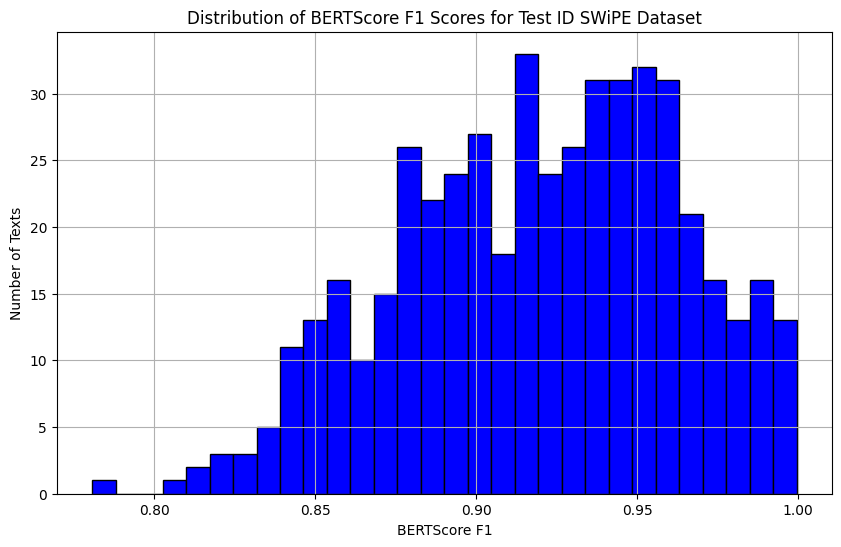

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_scores['bert_score'], bins=30, color='blue', edgecolor='black')
plt.title("Distribution of BERTScore F1 Scores for Test ID SWiPE Dataset")
plt.xlabel("BERTScore F1")
plt.ylabel("Number of Texts")
plt.grid(True)
plt.show()

In [27]:
for idx, row in df_scores[df_scores['bert_score']<=0.80].iterrows():
    print("ID = ", idx)
    print("Bscore = ", row['bert_score'])
    print("Raw: ",row['r_content'], end='\n\n')
    print(row['s_content'], end='\n\n')
    print("\n\n")

ID =  3
Bscore =  0.7806273698806763
Raw:  BOOK`S SUCK BOOKS SUCK BOOKS SUCKBOOK`S SUCK BOOKS SUCK BOOKS SUCKBOOK`S SUCK BOOKS SUCK BOOKS SUCKBOOK`S SUCK BOOKS SUCK BOOKS SUCK!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

A book is a set of printed sheets of paper held together between two covers. The sheets of paper are usually covered with a text: language and illustrations: that is the main point of a printed book. A book can also be a text in a larger collection of texts. This text has some features that do not apply to the collection as a whole. That way a book is perhaps written by one author, or it only treats one subject area. Books in this sense can often be understood without knowing the whole collection. Examples are the Bible, the Illiad or the Odyssey – all of them consist of a number of books in thi

In [28]:
indices_to_delete = df_scores[df_scores['bert_score']<=0.8].index.tolist()
print("Num of records to delete: ", len(indices_to_delete))

Num of records to delete:  1


In [29]:
print("Num of records: ", len(test_id_df))
test_id_df.drop(indices_to_delete, inplace=True)
print("Num of records: ", len(test_id_df))

Num of records:  484
Num of records:  483


## Test OOD dataset

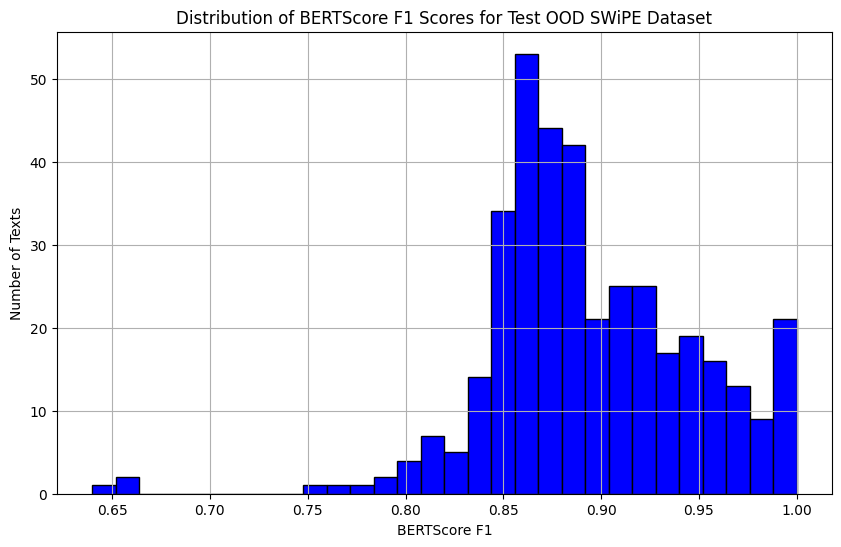

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_scores['bert_score'], bins=30, color='blue', edgecolor='black')
plt.title("Distribution of BERTScore F1 Scores for Test OOD SWiPE Dataset")
plt.xlabel("BERTScore F1")
plt.ylabel("Number of Texts")
plt.grid(True)
plt.show()

In [33]:
for idx, row in df_scores[df_scores['bert_score']<=0.80].iterrows():
    print("ID = ", idx)
    print("Bscore = ", row['bert_score'])
    print("Raw: ",row['r_content'], end='\n\n')
    print(row['s_content'], end='\n\n')
    print("\n\n")

ID =  7
Bscore =  0.7819263935089111
Raw:  [[Image:Triglyceride- families are recognised, collectively, as 'oil'. Scientists, instead of using the term 'oil', adopt the terms lipids and other terms to denote them instead.

The word oil is used for many different kinds of liquids. Oil usually does not mix with water.
Vegetable oils are made from plants. Many are used in foods and for cooking. Some kinds of plant oils that people use are palm oil, maize (corn), olive, peanut, soy, and sunflower.
Other kinds of oil are made from crude oil (petroleum) which comes from under the ground. People use large oil wells to bring the oil up to the surface. The oil is sent in special ships called tankers or in pipelines to factories called refineries where it is distilled into LPG, gasoline (petrol), diesel fuel, and fuel oil. Plastics are among the Petrochemicals made from crude oil or natural gas. Oils from crude oil are also used as fuels for engines or as lubricants to make the parts of machines

In [34]:
indices_to_delete = df_scores[df_scores['bert_score']<=0.8].index.tolist()
print("Num of records to delete: ", len(indices_to_delete))

Num of records to delete:  9


In [35]:
print("Num of records: ", len(test_ood_df))
test_ood_df.drop(indices_to_delete, inplace=True)
print("Num of records: ", len(test_ood_df))

Num of records:  377
Num of records:  368


# Clean-up

In [37]:
import re

def clean_text(text):
    # remove script errors or unwanted modules
    text = re.sub(r'Script error: No such module.*\.\n', '', text)
    
    # remove newline characters
    text = re.sub(r'\n', ' ', text)
    
    # remove redundant spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [38]:
train_df['r_content'] = train_df['r_content'].apply(clean_text)
train_df['s_content'] = train_df['s_content'].apply(clean_text)

val_df['r_content'] = val_df['r_content'].apply(clean_text)
val_df['s_content'] = val_df['s_content'].apply(clean_text)

test_id_df['r_content'] = test_id_df['r_content'].apply(clean_text)
test_id_df['s_content'] = test_id_df['s_content'].apply(clean_text)


test_ood_df['r_content'] = test_ood_df['r_content'].apply(clean_text)
test_ood_df['s_content'] = test_ood_df['s_content'].apply(clean_text)

# Save changes

In [50]:
print(len(train_df))
print(len(val_df))
print(len(test_id_df))
print(len(test_ood_df))

3861
479
483
368


In [51]:
train_dataset = Dataset.from_pandas(train_df[['r_content', 's_content','annotations','edits']].reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df[['r_content', 's_content','annotations','edits']].reset_index(drop=True))
test_id_dataset = Dataset.from_pandas(test_id_df[['r_content', 's_content','annotations','edits']].reset_index(drop=True))
test_ood_dataset = Dataset.from_pandas(test_ood_df[['r_content', 's_content','annotations','edits']].reset_index(drop=True))

swipe_dataset_cleaned = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test_id': test_id_dataset,
    'test_ood': test_ood_dataset
})

In [52]:
print("Train dataset: ", len(swipe_dataset_cleaned['train']))
print("Validation dataset: ", len(swipe_dataset_cleaned['validation']))
print("Test id dataset: ", len(swipe_dataset_cleaned['test_id']))
print("Test ood dataset: ", len(swipe_dataset_cleaned['test_ood']))

Train dataset:  3861
Validation dataset:  479
Test id dataset:  483
Test ood dataset:  368


In [53]:
swipe_dataset_cleaned

DatasetDict({
    train: Dataset({
        features: ['r_content', 's_content', 'annotations', 'edits'],
        num_rows: 3861
    })
    validation: Dataset({
        features: ['r_content', 's_content', 'annotations', 'edits'],
        num_rows: 479
    })
    test_id: Dataset({
        features: ['r_content', 's_content', 'annotations', 'edits'],
        num_rows: 483
    })
    test_ood: Dataset({
        features: ['r_content', 's_content', 'annotations', 'edits'],
        num_rows: 368
    })
})

In [56]:
from datasets import DatasetDict

swipe_dataset_cleaned.save_to_disk("../data/swipe_clean_annotated")

Saving the dataset (0/1 shards):   0%|          | 0/3861 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/479 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/483 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/368 [00:00<?, ? examples/s]